<a href="https://colab.research.google.com/github/dhakehruturaj/Topics-in-Generative-AI/blob/main/Lab_Session_3__RNN_and_Sequencing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topics in Generative AI: Lab Session 3

## Recurrent Neural Networks (RNN) and Sequence Mining

Welcome to the third lab session of the workshop on Topics in Generative AI. In this session, we will dive into Recurrent Neural Networks (RNNs) and Sequence Mining. The focus will be on understanding the basic concepts of RNNs, building a simple RNN model, and exploring Long Short-Term Memory (LSTM) networks.

### Table of Contents
1. Introduction to RNNs
2. Building a Simple RNN
3. Understanding LSTM Networks
4. Hands-On: Implementing LSTM

---

## Recurrent Neural Network

## 1. Introduction to RNNs

Recurrent Neural Networks (RNNs) are a class of neural networks that are well-suited for processing sequential data. Unlike traditional feedforward neural networks, RNNs have connections that form directed cycles, enabling them to maintain a 'memory' of previous inputs.

### Key Concepts:
- **Sequential Data:** Data where the order of the elements matters, such as time series, text, and speech.
- **Hidden State:** The memory of the network that captures information about previous inputs.
- **Recurrent Connections:** Connections that feed the output of a node back into the network as input for the next time step.

---

## 2. Building a Simple RNN

In this section, we will build a simple RNN from scratch using TensorFlow and Keras. The goal is to understand how RNNs process sequential data.

### Steps:
1. Import necessary libraries
2. Prepare the dataset
3. Define the RNN model
4. Train the model
5. Evaluate the model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import math
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

# Simple RNN to Learn Sine Wave

In this section, we will build a simple Recurrent Neural Network (RNN) to reproduce a sine wave based on the provided training data.

#### Understanding the Input Tensor for RNN

The input tensor for an RNN must be in the shape of `(sequence_length, batch_size, input_size)`. Let's break down these dimensions:

- **`sequence_length`**: This is the length of the sine wave sequence. We set this dimension to `-1` to allow it to adapt to any length if the other dimensions have a fixed size.
- **`batch_size`**: This represents the number of sequences we are training together. Since we only have one input sine wave in this example, we set this to `1`.
- **`input_size`**: This is the number of features at each time step. For a sine wave, we have one `x` value at a time, so this dimension is set to `1`.

To reshape our input data into the required dimensions, we will use the [view(.)](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view) function from PyTorch.



In [2]:
num_time_steps = 15

time_steps = np.linspace(0, 2*np.pi, num_time_steps)
data = np.sin(time_steps)
xs = data[:-1]
ys = data[1:]
train_x = torch.Tensor(xs).view(-1, 1, 1)
train_y = torch.Tensor(ys)

### Building a Simple RNN

The simplest RNN architecture includes an RNN cell and a fully connected layer. The RNN cell processes the input sequence step-by-step, while the fully connected layer converts the hidden state outputs into the final predicted values.

#### Key Components:
- **RNN Cell**: This is the core component that processes the input sequence and maintains hidden states across time steps.
- **Fully Connected Layer**: This layer reads the output from the RNN cell's hidden states and produces the final predictions.

#### Forward Method Explained:

In the `forward` method, the RNN processes the input sequence one time step at a time. This process is known as "unrolling" the RNN. For each time step, the following operations are performed:

1. **Recurrent Computation**: The RNN cell processes the input at the current time step and updates the hidden state.
2. **Prediction**: The fully connected layer generates an output value from the hidden state.

Additionally, the `forward` method returns:
- **Predicted Output Values**: The sequence of predicted values for each time step.
- **Hidden State Vector**: The hidden state at the final time step, which can be used to continue the sequence if needed.

Here's an example implementation in PyTorch:

In [3]:
class SimpleRNN(nn.Module):
    def __init__(self, hidden_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size=1,
                          hidden_size=hidden_size,
                          num_layers=1)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, seq, hc=None):
        tmp, hc = self.rnn(seq, hc)
        out = self.linear(tmp)
        return out, hc

We can set the hyperparameters and run training as before. Again, we use mean squared error to compute the loss for the real values.

In [4]:
hidden_size = 16
learning_rate = 0.001

model = SimpleRNN(hidden_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), learning_rate)

In [5]:
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    output, _ = model(train_x)
    loss = criterion(output.view(-1), train_y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print("Epoch {}: loss {}".format(epoch, loss.item()))

Epoch 0: loss 0.585710346698761
Epoch 10: loss 0.5003357529640198
Epoch 20: loss 0.4259280562400818
Epoch 30: loss 0.34804144501686096
Epoch 40: loss 0.2663826048374176
Epoch 50: loss 0.17929919064044952
Epoch 60: loss 0.10343654453754425
Epoch 70: loss 0.04457920044660568
Epoch 80: loss 0.010381437838077545
Epoch 90: loss 0.003533517476171255


### Re-generating the Sine Wave

To re-generate the sine wave, we need to provide the `x` values to the network. The RNN maintains a tensor for the hidden state throughout the prediction process. Initially, this hidden state is set to `None`, meaning the RNN will initialize it as a vector of all zeros.


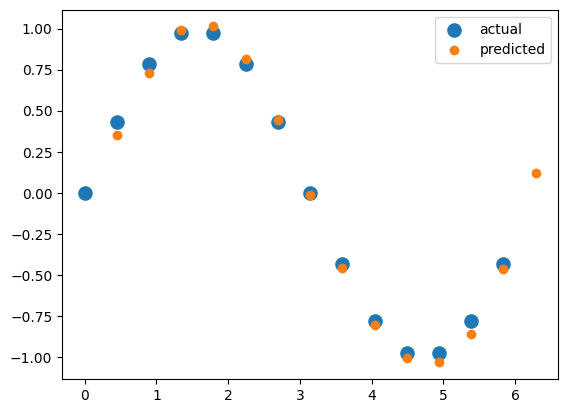

In [6]:
predictions = []
input = train_x[0, :, :]  # choose the first time step as input
hidden_prev = None
for i in range(train_x.shape[0]):
    input = train_x[i, :, :]
    input = input.view(1, 1, 1)
    pred, hidden_prev = model(input, hidden_prev)
    predictions.append(pred.data.numpy()[0])

x = train_x.data.numpy()
fig, ax = plt.subplots()
plt.scatter(time_steps[:-1], x, s=90, label='actual')
plt.scatter(time_steps[1:], predictions, label='predicted')
ax.legend()

The predicted values seem pretty well-aligned with the training sequence. You can try to give it a different input value to see how robust it is to different initial values.

### LSTM for POS Tagging

In this section, we will implement an LSTM-based model for Part-of-Speech (POS) tagging. POS tagging involves assigning a part-of-speech label to each word in a sentence (e.g., noun, verb, adjective).

#### Preparing the Input Data

To train our LSTM model, we need to convert sentences and their corresponding POS tags into a format suitable for neural network processing. Specifically, we will map each word to a unique index, allowing us to represent sentences as sequences of these indexes.

#### Steps to Prepare the Data:

1. **Tokenization**: Split the sentences into individual words (tokens).
2. **Vocabulary Creation**: Create a vocabulary of unique words from the dataset and assign an index to each word.
3. **Index Mapping**: Convert each word in the sentences to its corresponding index.
4. **Tag Mapping**: Similarly, convert each POS tag to its corresponding index.

By transforming the sentences and POS tags into sequences of indexes, we can easily manipulate and feed the data into tensors for training.


In [7]:
training_data = [
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]

word_to_ix = {}
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
print(word_to_ix)

tag_to_ix = {"DET": 0, "NN": 1, "V": 2}
print(tag_to_ix)

{'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8}
{'DET': 0, 'NN': 1, 'V': 2}


The model first represent words using word embeddings. Word embeddings are dense vectors of real numbers, one per word in your vocabulary. [`nn.Embedding`](https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding) allows us to build a lookup table to store the embeddings. It is also possible to use pre-trained word embeddings in your model (read example [here](https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76)).

Different from the RNNs, LSTMs also mantain a cell state. So, we can find the input and output tuple that contains a tensor for the hidden state and another tensor for the cell state. Both are initialized to all zeros. They have size (num_layers, batch_size, hidden_dim).

*  `num_layers`: We can have multiple LSTMs stacked on top of the others. If not specified, the default is one LSTM.
*  `batch_size`: This is the number of sentences we are going to train together. In this example, we train with one sentence a time.
*  `hidden_dim`: This is the length of vectors for the states.

Similar to the example in the CNN tutorial, we take softmax of the affine map of the hidden state to output the distribution over the label classes.




In [8]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_dim),
                torch.zeros(1, 1, self.hidden_dim))

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, self.hidden = self.lstm(
            embeds.view(len(sentence), 1, -1), self.hidden)
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

We have a function to convert a word to an index so that we can feed it to the input. As before, we use negative log likelihood as loss function.

The dimensions for word embedding and hidden states are quite small. Usually, you need a much larger size for real dataset.

In [9]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

embedding_dim = 6
hidden_dim = 6

model = LSTMTagger(embedding_dim, hidden_dim, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

Following the same steps, we train the LSTM model and check out the predicted tag for each word!

In [10]:
for epoch in range(300):
    for sentence, tags in training_data:
        optimizer.zero_grad()
        model.hidden = model.init_hidden()

        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)
        tag_scores = model(sentence_in)

        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
    if epoch % 50 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.item()))

# See what the scores are after training
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)
    _, predicted = torch.max(tag_scores, 1)
    print(training_data[0][0])
    print(predicted)

epoch 0, loss 1.0809142589569092
epoch 50, loss 0.9004238843917847
epoch 100, loss 0.4467942714691162
epoch 150, loss 0.12857668101787567
epoch 200, loss 0.05740232393145561
epoch 250, loss 0.034556835889816284
['The', 'dog', 'ate', 'the', 'apple']
tensor([0, 1, 2, 0, 1])


### Exercise: Generating Shakespeare

In the example above, we work on the word level classification. However, there are cases we may want to generate character one at a time. For example, deciding which character we want to capitalize or generating reasonable names, etc.

In this exercise, you will need to implement a model similar to what we have before but at character level to generate Shakespeare style texts.

First, let's download the training data!

Instead of input a big file for training, we will pick random chunks from the file as the input training sequences.

In [11]:
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 2.9 MB/s eta 0:00:00


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import string
import unidecode

In [13]:
input_file = 'input.txt'
!if [ ! -f $input_file ]; then wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt; fi

file = unidecode.unidecode(open('input.txt').read())

def random_chunk(chunk_len=200):
    start_index = random.randint(0, len(file) - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

--2024-07-21 17:59:05--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.03s   

2024-07-21 17:59:05 (32.9 MB/s) - ‘input.txt’ saved [1115394/1115394]

Servingman:
A marvellous poor one.

CORIOLANUS:
True, so I am.

Third Servingman:
Pray you, poor gentleman, take up some other
station; here's no place for you; pray you, avoid: come.

CORIOLANUS:
Foll


Similar to words, we convert words to integer indexes. Each character now has a unique id.

We also provide a function to produce a random training sequence. The input is the character at time $t$. The target is the expected character to see at $t+1$.

In [14]:
# Turn string into list of longs
# Each character is represented as an integer
def char_tensor(str):
    tensor = torch.zeros(len(str)).long()
    for c in range(len(str)):
        tensor[c] = string.printable.index(str[c])
    return tensor

def random_train_data():
    chunk = random_chunk()
    input = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return input, target

Now, it's your turn to implement the model!

This model will take as input the character for time step $t$ and is expected to output the character at $t+1$. There are three layers - one embedding layer that encodes the input character into a dense vector, one GRU layer (yes, let's try GRU instead of LSTM this time!) that operates on that dense vector and a hidden state, and a decoder layer that outputs the probability distribution over all possible characters.

You can take a look at the GRU documentation ([`nn.GRU`](https://pytorch.org/docs/stable/nn.html#torch.nn.GRU)), the usage is very similar to RNNs and LSTMs.

In [15]:
class ShakespeareRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(ShakespeareRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, n_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size)

    def forward(self, input, hidden):
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded.view(1, -1, self.hidden_size), hidden)
        output = self.decoder(output.view(-1, self.hidden_size))
        return output, hidden

To check out the generation result, we provide you an evaluate function so you can pick any character to start with to generate a paragraph using the trained model.

The generation process works as follows. We will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat.

In [16]:
def evaluate(model, prime_str='A', predict_len=100):
    hidden = model.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    for p in range(len(prime_str) - 1):
        _, hidden = model(prime_input[p].unsqueeze(0), hidden)
    input = prime_input[-1].unsqueeze(0)

    for p in range(predict_len):
        output, hidden = model(input, hidden)
        output_dist = output.data.view(-1).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        predicted_char = string.printable[top_i]
        predicted += predicted_char
        input = char_tensor(predicted_char).unsqueeze(0)

    return predicted

Finally, we define the training parameters, instantiate the model, and start training.

Please complete the missing training script! Once you start training, you can see how the generated texts evolve every 100 epoch.

Importing Dataset

In [17]:
n_characters = len(string.printable)
hidden_size = 100
n_layers = 1

epochs = 2000
lr = 0.005

model = ShakespeareRNN(n_characters, hidden_size, n_characters, n_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    loss = 0
    input_tensor, target_tensor = random_train_data()
    chunk_len = input_tensor.size(0)

    hidden = model.init_hidden()

    for c in range(chunk_len):
        output, hidden = model(input_tensor[c].unsqueeze(0), hidden)
        loss += criterion(output, target_tensor[c].unsqueeze(0))

    loss.backward()
    optimizer.step()

    loss = loss.item() / chunk_len
    if epoch % 100 == 0:
        print('[(%d %d%%) %.4f]' % (epoch, epoch / epochs * 100, loss))
        print(evaluate(model, 'Wh', 100), '\n')


[(0 0%) 4.5850]
Wh;.8`['14'Hz!Ac	x7dmrKpO+M0E(Cr2^;uxMLK+tHS
0*GH^Z0i$)2/irxQJ5G)Pf{=>>Ko;bORos;T|1KleM{IM2/Ce8}FC 

[(100 5%) 2.3214]
Whome why mrot hind bfow, sham of inire anl har pofr ande what sils, me sta lom
Thin dad,

MUA:

Shand 

[(200 10%) 2.2174]
Whinestubleor limrorm;
I or Carlisese berser thachic.

Deas, fas lave the verether fathed herser oqe a 

[(300 15%) 2.0854]
Whackfot I thowst.

JUNET:
Shine yor:
Show?
Th I the
Thall that sener you tanou mart tine surno,
And h 

[(400 20%) 2.1133]
Whis you cin gethy lon thee, I withy my lether, Buediok?
En? ther such
Aived eren The vicleds by whis  

[(500 25%) 2.0395]
Whour it whis it how sit witen.

VEOMEROVVERD:
Is I haichardel trom?

LADY ISANUS:

MANIE
HSNIUS: geso 

[(600 30%) 1.9363]
Wheirsing on the mende daivelfou comst has brongele.

PONCER:
Freive, thoush vertaur, the sods, and da 

[(700 35%) 2.0413]
Which wand thy shaions speess kint;
And best Evereves man mand
Thouser's ons
and lo's vowss araist spo 

[(800 40%) 1



### Problem: You have to perform Toxic Comment Classification

Dataset link: https://drive.google.com/drive/folders/1SQerqMNAAh_BU3IBj4gAvjcQBsoDchAt?usp=sharing

In [19]:
!wget https://www.google.com/url?q=https%3A%2F%2Fdrive.google.com%2Fdrive%2Ffolders%2F1SQerqMNAAh_BU3IBj4gAvjcQBsoDchAt%3Fusp%3Dsharing -p

--2024-07-21 18:14:33--  https://www.google.com/url?q=https%3A%2F%2Fdrive.google.com%2Fdrive%2Ffolders%2F1SQerqMNAAh_BU3IBj4gAvjcQBsoDchAt%3Fusp%3Dsharing
Resolving www.google.com (www.google.com)... 142.250.101.104, 142.250.101.99, 142.250.101.106, ...
Connecting to www.google.com (www.google.com)|142.250.101.104|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.google.com/drive/folders/1SQerqMNAAh_BU3IBj4gAvjcQBsoDchAt?usp=sharing [following]
--2024-07-21 18:14:33--  https://drive.google.com/drive/folders/1SQerqMNAAh_BU3IBj4gAvjcQBsoDchAt?usp=sharing
Resolving drive.google.com (drive.google.com)... 142.250.101.138, 142.250.101.139, 142.250.101.113, ...
Connecting to drive.google.com (drive.google.com)|142.250.101.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘www.google.com/url?q=https:%2F%2Fdrive.google.com%2Fdrive%2Ffolders%2F1SQerqMNAAh_BU3IBj4gAvjcQBsoDchAt?usp=sharing’



In [24]:
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import GloVe
from collections import Counter

In [25]:

# Load the data
train_data = pd.read_csv("/content/training_data.csv", index_col=False)
test_data = pd.read_csv("/content/test_data.csv", index_col=False)

train_data.head(), test_data.head()

(                 id                                       comment_text  toxic  \
 0  da436ad42040d6df  ; 25 March 2013 (UTC). . That's some strange i...      0   
 1  d1dde89e13a40d9e  . {| style="background-color: #F5FFFA; padding...      0   
 2  521e64c55abc6137  I see that my edits have apparently been rever...      0   
 3  5c5d871fac358990  Art of War/Wall Street Quote. I have just pull...      0   
 4  4cfff81b9d14275d  . . Do either of them have a source? Unless th...      0   
 
    severe_toxic  obscene  threat  insult  identity_hate  no_toxicity  
 0             0        0       0       0              0            1  
 1             0        0       0       0              0            1  
 2             0        0       0       0              0            1  
 3             0        0       0       0              0            1  
 4             0        0       0       0              0            1  ,
                  id                                       comment_text
 

In [27]:

train_data = train_data[train_data["comment_text"] != ""].dropna()
train_data["comment_text"] = train_data["comment_text"].apply(preprocess_text)

In [30]:
train_data['no_toxicity'].value_counts()

no_toxicity
1    125247
0     14199
Name: count, dtype: int64

In [31]:
# separating the data for analysis
toxic = train_data[train_data.no_toxicity == 0]
non_toxic = train_data[train_data.no_toxicity == 1]

In [32]:
non_toxic_sample = non_toxic.sample(n=15000)

In [33]:
new_dataset = pd.concat([non_toxic_sample, toxic], axis=0)

In [34]:
train_data = new_dataset

<Axes: >

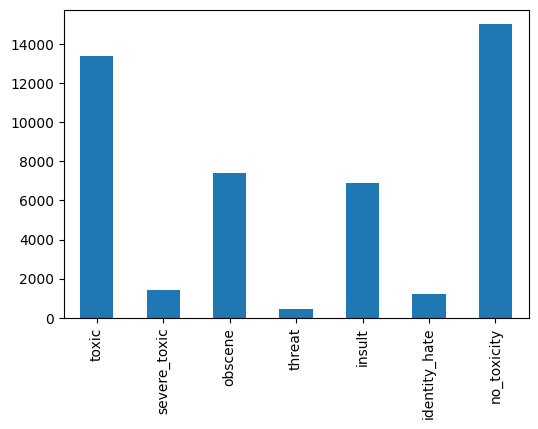

In [35]:
toxic_comments_labels = train_data[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate", "no_toxicity"]]

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

toxic_comments_labels.sum(axis=0).plot.bar()

In [26]:

# Preprocess text
def preprocess_text(sen):
    sentence = re.sub('[^a-zA-Z]', ' ', sen)
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence.strip()

In [36]:
X = []
sentences = list(train_data["comment_text"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = toxic_comments_labels.values

In [38]:

# Prepare data for training
X = new_dataset["comment_text"]
y = new_dataset[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate", "no_toxicity"]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [39]:
# Tokenize and build vocabulary
tokenizer = get_tokenizer("basic_english")
counter = Counter()
for sentence in X_train:
    counter.update(tokenizer(sentence))
vocab = GloVe(name="6B", dim=100, cache='/content')

/content/glove.6B.zip: 862MB [02:39, 5.42MB/s]                           
100%|█████████▉| 399999/400000 [00:32<00:00, 12398.13it/s]


In [40]:
# Convert sentences to indices
def encode(sentence, vocab, tokenizer):
    return [vocab.stoi[word] for word in tokenizer(sentence) if word in vocab.stoi]

X_train = [encode(sentence, vocab, tokenizer) for sentence in X_train]
X_test = [encode(sentence, vocab, tokenizer) for sentence in X_test]

# Pad sequences
X_train = pad_sequence([torch.tensor(x) for x in X_train], batch_first=True, padding_value=0)
X_test = pad_sequence([torch.tensor(x) for x in X_test], batch_first=True, padding_value=0)

In [41]:
# Define the model architecture in PyTorch
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, weights):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(weights)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out[:, -1, :]  # take the last LSTM output
        output = self.fc(lstm_out)
        output = self.sigmoid(output)
        return output

In [42]:
# Prepare embedding matrix
embedding_matrix = vocab.vectors
vocab_size, embedding_dim = embedding_matrix.shape

In [43]:

# Convert data to PyTorch DataLoader
train_dataset = TensorDataset(X_train, torch.FloatTensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [44]:
# Initialize model, loss function, and optimizer
model = LSTMModel(vocab_size, embedding_dim, 128, 7, torch.tensor(embedding_matrix))
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

<ipython-input-44-a3cf90ca742e>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model = LSTMModel(vocab_size, embedding_dim, 128, 7, torch.tensor(embedding_matrix))


In [ ]:
# Training loop
epochs = 5
model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader)}')

In [ ]:
# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test).detach().numpy()

# Example of saving predictions to a CSV (similar to the original code)
predictions = pd.DataFrame(np.rint(y_pred).astype(int), columns=["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate", "no_toxicity"])
predictions['comment_id'] = test_data['id']
predictions.to_csv('y_pred_predicted.csv', index=False)


### References:

1. Deep learning tutorial BMM: [Link](https://cbmm.mit.edu/sites/default/files/documents/BMM%202018%20-%20Deep%20Learning%20Tutorial.pdf)

